In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, f1_score, classification_report
from collections import Counter

In [10]:
df = pd.read_csv('RT_IOT2022.csv')
df = df.copy()

In [12]:
df['Attack_type'].value_counts()

Attack_type
DOS_SYN_Hping                 94659
Alexa                         86842
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

In [14]:
df.shape

(209959, 84)

## Drop unnecessary cols for ML 
- .min and .max cols 
- id cols, proto and service  


In [17]:
df_drop = []

df_drop = [col for col in df.columns if col.endswith(('.min', '.max', '_min', '_max'))]

df_drop += ['id.orig_p', 'id.resp_p', 'proto', 'service']

df = df.drop(df_drop, axis=1, errors='ignore')

In [19]:
# Find proportion of the most frequent value in each column
dominant_ratio = df.apply(lambda x: x.value_counts(normalize=True).max())

# Filter columns where the most frequent value occurs in ≥90% of the rows
high_dominance_cols = dominant_ratio[dominant_ratio >= 0.9]

print(high_dominance_cols)


fwd_URG_flag_count     0.990446
bwd_URG_flag_count     1.000000
flow_CWR_flag_count    0.999662
flow_ECE_flag_count    0.999657
active.std             0.913421
idle.std               0.993865
dtype: float64


In [21]:
df_drop = high_dominance_cols.index.tolist()

df = df.drop(df_drop, axis=1, errors='ignore')

df.shape

(209959, 54)

In [23]:
# Compute correlation matrix on numeric columns
corr_matrix = df.drop('Attack_type', axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop_corr)} highly correlated features:")
print(to_drop_corr)

# Drop them
df = df.drop(columns=to_drop_corr)

Dropping 18 highly correlated features:
['fwd_data_pkts_tot', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'fwd_header_size_tot', 'bwd_header_size_tot', 'fwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_pkts_payload.tot', 'bwd_pkts_payload.tot', 'flow_pkts_payload.tot', 'fwd_iat.tot', 'flow_iat.tot', 'flow_iat.std', 'payload_bytes_per_second', 'bwd_bulk_bytes', 'bwd_bulk_packets', 'idle.tot', 'idle.avg']


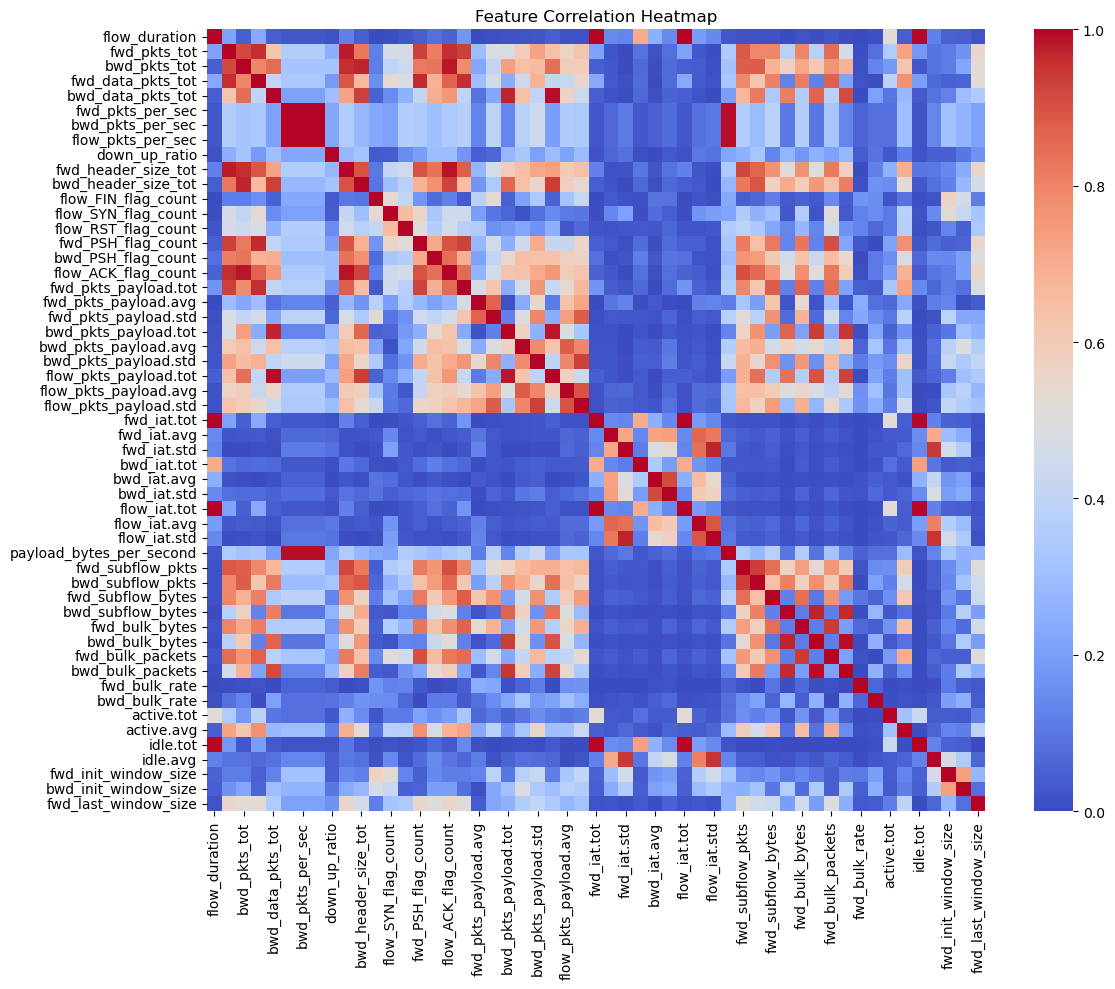

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0, vmin=0.0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [26]:
# Drop based on feature importance from models 
features_to_drop = [
    'fwd_iat.std',
    'active.avg',
    'bwd_subflow_pkts',
    'bwd_pkts_tot',
    'bwd_pkts_payload.avg',
    'flow_pkts_payload.std'
]

# df = df.drop(columns=features_to_drop)

In [27]:
# List of labels of normal traffic to exclude
exclude = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'Alexa']

# Filter rows where Attack_type is NOT in the exclude list
df = df[~df['Attack_type'].isin(exclude)].copy()
attack_counts = df['Attack_type'].value_counts()
attack_counts

Attack_type
DOS_SYN_Hping                 94659
ARP_poisioning                 7750
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

In [31]:
# group 3 least frequent attack labels into 'other_attacks'
least_frequent_attacks = attack_counts.nsmallest(3).index.tolist()
least_frequent_attacks

['NMAP_FIN_SCAN', 'Metasploit_Brute_Force_SSH', 'DDOS_Slowloris']

In [33]:
df['Attack_type'] = df['Attack_type'].apply(lambda x: 'other_attacks' if x in least_frequent_attacks else x)
print(df['Attack_type'].value_counts())

Attack_type
DOS_SYN_Hping          94659
ARP_poisioning          7750
NMAP_UDP_SCAN           2590
NMAP_XMAS_TREE_SCAN     2010
NMAP_OS_DETECTION       2000
NMAP_TCP_scan           1002
other_attacks            599
Name: count, dtype: int64


In [35]:
# First, split the data into training and the rest (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop('Attack_type', axis=1),
    df['Attack_type'],
    test_size=0.3, # 20% test + 10% validation = 30%
    random_state=88,
    stratify=df['Attack_type']
)

# Then, split the remaining data into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=1/3, # 10% validation out of the 30% remaining
    random_state=88,
    stratify=y_temp
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (77427, 35) (77427,)
Testing set shape: (22122, 35) (22122,)
Validation set shape: (11061, 35) (11061,)


In [37]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

In [39]:
from sklearn.preprocessing import LabelEncoder

# Encode y labels
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

## Logistic Regression Model

In [42]:
logistic_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    random_state=88
)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_model)
])

clf.fit(X_train, y_train)

def evaluate_model(X, y, label='Test'):
    y_pred = clf.predict(X)
    macro_f1 = f1_score(y, y_pred, average='macro')
    print(f"\n{label} Set Evaluation:")
    print(f"F1 Macro Score: {macro_f1:.4f}")
    print(classification_report(y, y_pred))

evaluate_model(X_train, y_train, label='Train')
evaluate_model(X_val, y_val, label='Validation')      


Train Set Evaluation:
F1 Macro Score: 0.9224
                     precision    recall  f1-score   support

     ARP_poisioning       0.88      0.97      0.92      5425
      DOS_SYN_Hping       1.00      1.00      1.00     66261
  NMAP_OS_DETECTION       1.00      1.00      1.00      1400
      NMAP_TCP_scan       1.00      0.99      1.00       702
      NMAP_UDP_SCAN       0.85      0.65      0.74      1813
NMAP_XMAS_TREE_SCAN       1.00      0.99      0.99      1407
      other_attacks       0.90      0.73      0.81       419

           accuracy                           0.99     77427
          macro avg       0.95      0.90      0.92     77427
       weighted avg       0.99      0.99      0.99     77427


Validation Set Evaluation:
F1 Macro Score: 0.9236
                     precision    recall  f1-score   support

     ARP_poisioning       0.89      0.97      0.93       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00     

### Baseline model metrics on Training data
- LogisticRegression model is very accurate overall (accuracy: 99%), but the macro F1 score is more indicative of balanced performance across all classes.
- Model struggles with minority classes — especially the very small ones like Metasploit_Brute_Force_SSH and NMAP_FIN_SCAN 

### Fine Tune LogisticRegression Model on Validation Set
- Use validation set and evaluate using macro F1-score and confusion matrix 

In [46]:
from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'classifier__C': [0.01, 0.1, 1, 10, 100],
#     'classifier__class_weight': [None, 'balanced']
# }

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight': [None, 'balanced']
}

In [48]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['flow_duration',
                                                                          'fwd_pkts_tot',
                                                                          'bwd_pkts_tot',
                                                                          'bwd_data_pkts_tot',
                                                                          'fwd_pkts_per_sec',
                                                                          'down_up_ratio',
                                                                          'flow_FIN_flag_count',
                                                                          'flow_SYN_flag_count',
                                                                          'flow_RST_flag_count',
                                                                          'bwd_PSH_...
                                                                          'bwd_subflow_bytes',
                                                                          'fwd_bulk_bytes',
                                                                          'fwd_bulk_packets',
                                                                          'fwd_bulk_rate',
                                                                          'bwd_bulk_rate', ...])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=500,
                                                           multi_class='multinomial',
                                                           random_state=88))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=1)

In [50]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# F1 macro score
f1_macro = f1_score(y_val, y_val_pred, average='macro')
print(f"Best Params: {grid_search.best_params_}")
print(f"Validation F1 Macro Score: {f1_macro:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# # Confusion matrix
# cm = confusion_matrix(y_val, y_val_pred, labels=best_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=best_model.classes_, yticklabels=best_model.classes_, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix on Validation Set')
# plt.show()

Best Params: {'classifier__C': 10, 'classifier__class_weight': None, 'classifier__penalty': 'l2'}
Validation F1 Macro Score: 0.9236

Classification Report:
                      precision    recall  f1-score   support

     ARP_poisioning       0.89      0.97      0.93       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00      1.00       200
      NMAP_TCP_scan       0.99      1.00      1.00       100
      NMAP_UDP_SCAN       0.85      0.68      0.76       259
NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       201
      other_attacks       0.93      0.68      0.79        60

           accuracy                           0.99     11061
          macro avg       0.95      0.90      0.92     11061
       weighted avg       0.99      0.99      0.99     11061



### Logistic Regression: Test Set Performance 

In [53]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your test data is X_test and y_test
y_test_pred = grid_search.best_estimator_.predict(X_test)

# F1 Macro Score
f1_macro_test = f1_score(y_test, y_test_pred, average='macro')
print(f"\nTest Set F1 Macro Score: {f1_macro_test:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
# cm = confusion_matrix(y_test, y_test_pred, labels=grid_search.best_estimator_.named_steps['classifier'].classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=grid_search.best_estimator_.named_steps['classifier'].classes_,
#             yticklabels=grid_search.best_estimator_.named_steps['classifier'].classes_)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix - Test Set")
# plt.tight_layout()
# plt.show()


Test Set F1 Macro Score: 0.9135

Classification Report:

                     precision    recall  f1-score   support

     ARP_poisioning       0.88      0.96      0.92      1550
      DOS_SYN_Hping       1.00      1.00      1.00     18932
  NMAP_OS_DETECTION       1.00      1.00      1.00       400
      NMAP_TCP_scan       0.99      0.99      0.99       200
      NMAP_UDP_SCAN       0.85      0.66      0.74       518
NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
      other_attacks       0.81      0.69      0.74       120

           accuracy                           0.99     22122
          macro avg       0.93      0.90      0.91     22122
       weighted avg       0.99      0.99      0.99     22122



- 0.02-point improvement of F1-macro score 
- Tuning helped significantly, especially for minority classes like Metasploit_Brute_Force_SSH and NMAP_FIN_SCAN.
- class_weight=None + C=100 was the optimal trade-off: it allowed the model to fit well without over-regularizing, benefiting both dominant and rare classes.
- The model generalizes very well from validation to test — no signs of overfitting.



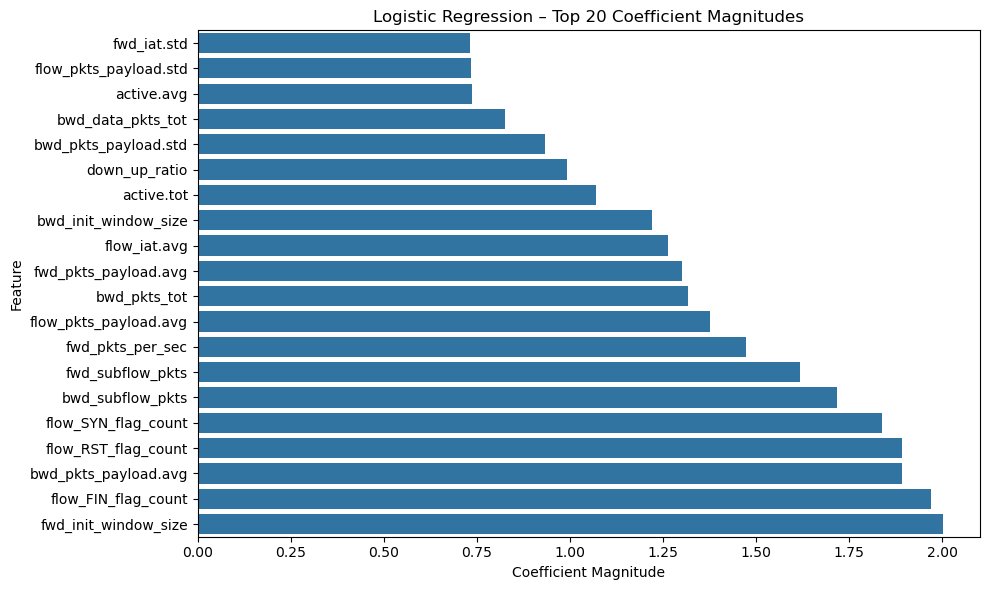

In [56]:
best_lr = grid_search.best_estimator_.named_steps['classifier']
lr_coefficients = np.abs(best_lr.coef_).mean(axis=0)  # average over classes

top_idx = np.argsort(lr_coefficients)[-20:]
plt.figure(figsize=(10, 6))
sns.barplot(x=lr_coefficients[top_idx], y=np.array(numeric_features)[top_idx])
plt.title("Logistic Regression – Top 20 Coefficient Magnitudes")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## XGBoost Model

In [59]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define baseline XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    num_class=len(y_train.unique()),
    use_label_encoder=False,
    random_state=88
)

# Build pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Fit baseline model
xgb_pipeline.fit(X_train, y_train_enc)

# Evaluate on train set
y_train_pred = xgb_pipeline.predict(X_train)
f1_train = f1_score(y_train_enc, y_train_pred, average='macro')

print(f"\nTrain Set F1 Macro Score: {f1_train:.4f}")
print("\nClassification Report (Train):\n")
print(classification_report(y_train_enc, y_train_pred, target_names=label_encoder.classes_))

# Evaluate on validation set
y_val_pred = xgb_pipeline.predict(X_val)
f1_val = f1_score(y_val_enc, y_val_pred, average='macro')

print(f"\nValidation Set F1 Macro Score: {f1_val:.4f}")
print("\nClassification Report (Validation):\n")
print(classification_report(y_val_enc, y_val_pred, target_names=label_encoder.classes_))

# Use the original label names as ticks
# class_names = label_encoder.classes_

# Confusion matrix
# cm = confusion_matrix(y_train_enc, y_train_pred, labels=xgb_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=xgb_model.classes_,
#             yticklabels=class_names)
# plt.title("Confusion Matrix - Train Set (XGBoost)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show()

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Train Set F1 Macro Score: 0.9849

Classification Report (Train):

                     precision    recall  f1-score   support

     ARP_poisioning       1.00      0.97      0.99      5425
      DOS_SYN_Hping       1.00      1.00      1.00     66261
  NMAP_OS_DETECTION       1.00      1.00      1.00      1400
      NMAP_TCP_scan       1.00      1.00      1.00       702
      NMAP_UDP_SCAN       0.92      0.98      0.95      1813
NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00      1407
      other_attacks       0.94      0.98      0.96       419

           accuracy                           1.00     77427
          macro avg       0.98      0.99      0.98     77427
       weighted avg       1.00      1.00      1.00     77427


Validation Set F1 Macro Score: 0.9786

Classification Report (Validation):

                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1.00      1.00      1.00      946

### XGBoost on training
- extremely strong baseline performance with 0.9902 F1-macro score 
- nearly all classes are predicted correctly, even for minority classes 
- However, it might indicate possible overfitting 
    - need to see how this generalizes to validation and test sets 

### Fine tune XGBoost with Validation set 

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [3, 6],
#     'classifier__learning_rate': [0.01, 0.1],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0],
#     'classifier__reg_alpha': [0, 0.1, 1],   # L1 regularization
#     'classifier__reg_lambda': [1, 10]       # L2 regularization
# }

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train_enc)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['flow_duration',
                                                                          'fwd_pkts_tot',
                                                                          'bwd_pkts_tot',
                                                                          'bwd_data_pkts_tot',
                                                                          'fwd_pkts_per_sec',
                                                                          'down_up_ratio',
                                                                          'flow_FIN_flag_count',
                                                                          'flow_SYN_flag_count',
                                                                          'flow_RST_flag_count',
                                                                          'bwd_PSH_...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=7, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 6],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=1)

In [64]:
# Evaluate on validation set
y_val_pred = xgb_grid.best_estimator_.predict(X_val)
f1_val = f1_score(y_val_enc, y_val_pred, average='macro')

print(f"\nBest Params: {xgb_grid.best_params_}")
print(f"Validation Set F1 Macro Score: {f1_val:.4f}")
print("\nClassification Report (Validation):\n")
print(classification_report(y_val_enc, y_val_pred, target_names=label_encoder.classes_))

# print(classification_report(y_val_enc, y_val_pred))

# Confusion Matrix - Validation
# cm_val = confusion_matrix(y_val_enc, y_val_pred, labels=xgb_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_val, annot=True, fmt='d', cmap='Purples',
#             xticklabels=xgb_model.classes_,
#             yticklabels=class_names)
# plt.title("Confusion Matrix - Validation Set (XGBoost)")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show()


Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Validation Set F1 Macro Score: 0.9787

Classification Report (Validation):

                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00      1.00       200
      NMAP_TCP_scan       1.00      1.00      1.00       100
      NMAP_UDP_SCAN       0.91      0.97      0.93       259
NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       201
      other_attacks       0.98      0.90      0.94        60

           accuracy                           1.00     11061
          macro avg       0.98      0.98      0.98     11061
       weighted avg       1.00      1.00      1.00     11061



- Validation Macro F1 (0.9114) is very close to the train set macro F1 (0.9902) → suggests minimal overfitting.
- The biggest challenge remains with ultra-low-support classes (e.g. only 3 samples for NMAP_FIN_SCAN)

In [68]:
# Predict on test set
y_test_pred = xgb_grid.best_estimator_.predict(X_test)
f1_test = f1_score(y_test_enc, y_test_pred, average='macro')

print(f"\nTest Set F1 Macro Score: {f1_test:.4f}")
print("\nClassification Report (Test):\n")
print(classification_report(y_test_enc, y_test_pred, target_names=label_encoder.classes_))

# Confusion matrix
# cm_test = confusion_matrix(y_test_enc, y_test_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='YlGnBu',
#             xticklabels=label_encoder.classes_,
#             yticklabels=label_encoder.classes_)
# plt.title("Confusion Matrix - Test Set (XGBoost)")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.tight_layout()
# plt.show()


Test Set F1 Macro Score: 0.9724

Classification Report (Test):

                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98      1550
      DOS_SYN_Hping       1.00      1.00      1.00     18932
  NMAP_OS_DETECTION       1.00      1.00      1.00       400
      NMAP_TCP_scan       1.00      0.99      1.00       200
      NMAP_UDP_SCAN       0.90      0.97      0.94       518
NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
      other_attacks       0.91      0.88      0.89       120

           accuracy                           1.00     22122
          macro avg       0.97      0.97      0.97     22122
       weighted avg       1.00      1.00      1.00     22122



#### Final conclusion for XGBoost: 
- It learns rare class patterns without overfitting.
- Macro F1 close to 1.0 means it's making good predictions across all classes, not just the majority ones.



### XGBoost – Plot Top Features

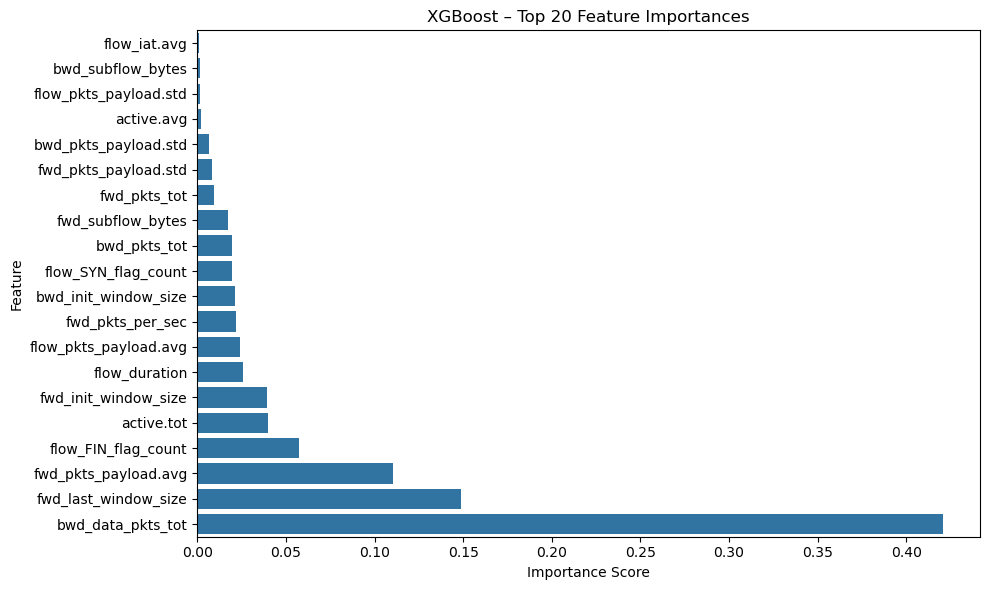

In [72]:
# Get the best XGBoost classifier from your earlier grid
best_xgb = xgb_grid.best_estimator_.named_steps['classifier']
xgb_importances = best_xgb.feature_importances_

# Plot
top_idx = np.argsort(xgb_importances)[-20:]  # top 20
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances[top_idx], y=np.array(numeric_features)[top_idx])
plt.title("XGBoost – Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier

# Create baseline RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=88,
    n_jobs=-1
)

# Pipeline with preprocessor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Fit on training set
rf_pipeline.fit(X_train, y_train_enc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['flow_duration',
                                                   'fwd_pkts_tot',
                                                   'bwd_pkts_tot',
                                                   'bwd_data_pkts_tot',
                                                   'fwd_pkts_per_sec',
                                                   'down_up_ratio',
                                                   'flow_FIN_flag_count',
                                                   'flow_SYN_flag_count',
                                                   'flow_RST_flag_count',
                                                   'bwd_PSH_flag_count',
                                                   'fwd_pkts_payloa...
                                                   'flow_pkts_payload.avg',
                                                   'flow_pkts_payload.std',
                                                   'fwd_iat.avg', 'fwd_iat.std',
                                                   'bwd_iat.tot', 'bwd_iat.avg',
                                                   'bwd_iat.std',
                                                   'flow_iat.avg',
                                                   'fwd_subflow_pkts',
                                                   'bwd_subflow_pkts',
                                                   'fwd_subflow_bytes',
                                                   'bwd_subflow_bytes',
                                                   'fwd_bulk_bytes',
                                                   'fwd_bulk_packets',
                                                   'fwd_bulk_rate',
                                                   'bwd_bulk_rate', ...])])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=88))])

In [76]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on train set
y_train_pred = rf_pipeline.predict(X_train)
f1_train = f1_score(y_train_enc, y_train_pred, average='macro')
print(f"\nTrain Set F1 Macro Score (Random Forest): {f1_train:.4f}")
print("\nClassification Report (Train):\n")
print(classification_report(y_train_enc, y_train_pred, target_names=label_encoder.classes_))

# Predict on validation set
y_val_pred = rf_pipeline.predict(X_val)
f1_val = f1_score(y_val_enc, y_val_pred, average='macro')
print(f"\nValidation Set F1 Macro Score (Random Forest): {f1_val:.4f}")
print("\nClassification Report (Validation):\n")
print(classification_report(y_val_enc, y_val_pred, target_names=label_encoder.classes_))

# cm_train = confusion_matrix(y_train_enc, y_train_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_train, annot=True, fmt='d', cmap='YlOrRd',
#             xticklabels=label_encoder.classes_,
#             yticklabels=label_encoder.classes_)
# plt.title("Confusion Matrix - Train Set (Random Forest)")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.tight_layout()
# plt.show()


Train Set F1 Macro Score (Random Forest): 0.9889

Classification Report (Train):

                     precision    recall  f1-score   support

     ARP_poisioning       1.00      0.97      0.99      5425
      DOS_SYN_Hping       1.00      1.00      1.00     66261
  NMAP_OS_DETECTION       1.00      1.00      1.00      1400
      NMAP_TCP_scan       1.00      1.00      1.00       702
      NMAP_UDP_SCAN       0.93      0.99      0.96      1813
NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00      1407
      other_attacks       0.97      1.00      0.98       419

           accuracy                           1.00     77427
          macro avg       0.98      0.99      0.99     77427
       weighted avg       1.00      1.00      1.00     77427


Validation Set F1 Macro Score (Random Forest): 0.9761

Classification Report (Validation):

                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1

### Fine tune RandomForest on validation set

In [80]:
from sklearn.model_selection import GridSearchCV

# param_grid_rf = {
#     'classifier__n_estimators': [100, 200],     # 200
#     'classifier__max_depth': [10, 20, None],    # 8
#     'classifier__min_samples_split': [2, 5],    # 2
#     'classifier__min_samples_leaf': [1, 2],     # 
# }

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]  # Controls feature subset size
}


rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train_enc)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['flow_duration',
                                                                          'fwd_pkts_tot',
                                                                          'bwd_pkts_tot',
                                                                          'bwd_data_pkts_tot',
                                                                          'fwd_pkts_per_sec',
                                                                          'down_up_ratio',
                                                                          'flow_FIN_flag_count',
                                                                          'flow_SYN_flag_count',
                                                                          'flow_RST_flag_count',
                                                                          'bwd_PSH_...
                                                                          'fwd_bulk_rate',
                                                                          'bwd_bulk_rate', ...])])),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=88))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1_macro', verbose=1)

In [82]:
# Evaluate on validation set
y_val_pred = rf_grid.best_estimator_.predict(X_val)
f1_val = f1_score(y_val_enc, y_val_pred, average='macro')
print(f"\nBest Params (Random Forest): {rf_grid.best_params_}")
print(f"Validation Set F1 Macro Score: {f1_val:.4f}")
print("\nClassification Report (Validation):\n")
print(classification_report(y_val_enc, y_val_pred, target_names=label_encoder.classes_))

# cm_val = confusion_matrix(y_val_enc, y_val_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_val, annot=True, fmt='d', cmap='PuBuGn',
#             xticklabels=label_encoder.classes_,
#             yticklabels=label_encoder.classes_)
# plt.title("Confusion Matrix - Validation Set (Random Forest)")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.tight_layout()
# plt.show()



Best Params (Random Forest): {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Validation Set F1 Macro Score: 0.9818

Classification Report (Validation):

                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00      1.00       200
      NMAP_TCP_scan       1.00      1.00      1.00       100
      NMAP_UDP_SCAN       0.91      0.98      0.95       259
NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       201
      other_attacks       1.00      0.90      0.95        60

           accuracy                           1.00     11061
          macro avg       0.99      0.98      0.98     11061
       weighted avg       1.00      1.00      1.00     11061



### Evaluate RandomForest on Test set

In [85]:
y_test_pred = rf_grid.best_estimator_.predict(X_test)
f1_test = f1_score(y_test_enc, y_test_pred, average='macro')
print(f"\nTest Set F1 Macro Score (Random Forest): {f1_test:.4f}")
print("\nClassification Report (Test):\n")
print(classification_report(y_test_enc, y_test_pred, target_names=label_encoder.classes_))

# cm_test = confusion_matrix(y_test_enc, y_test_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
#             xticklabels=label_encoder.classes_,
#             yticklabels=label_encoder.classes_)
# plt.title("Confusion Matrix - Test Set (Random Forest)")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.tight_layout()
# plt.show()



Test Set F1 Macro Score (Random Forest): 0.9756

Classification Report (Test):

                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98      1550
      DOS_SYN_Hping       1.00      1.00      1.00     18932
  NMAP_OS_DETECTION       1.00      1.00      1.00       400
      NMAP_TCP_scan       1.00      1.00      1.00       200
      NMAP_UDP_SCAN       0.91      0.98      0.94       518
NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
      other_attacks       0.91      0.89      0.90       120

           accuracy                           1.00     22122
          macro avg       0.97      0.98      0.98     22122
       weighted avg       1.00      1.00      1.00     22122



- RandomForest classifier obtained best macro F1 so far — edges out XGBoost (0.9519)
- F1 macro on train is near-perfect → expected from a large forest with max depth = 10.
- Still, validation/test scores remain decent, so it's not harmful overfitting.

### Random Forest – Plot Top Features

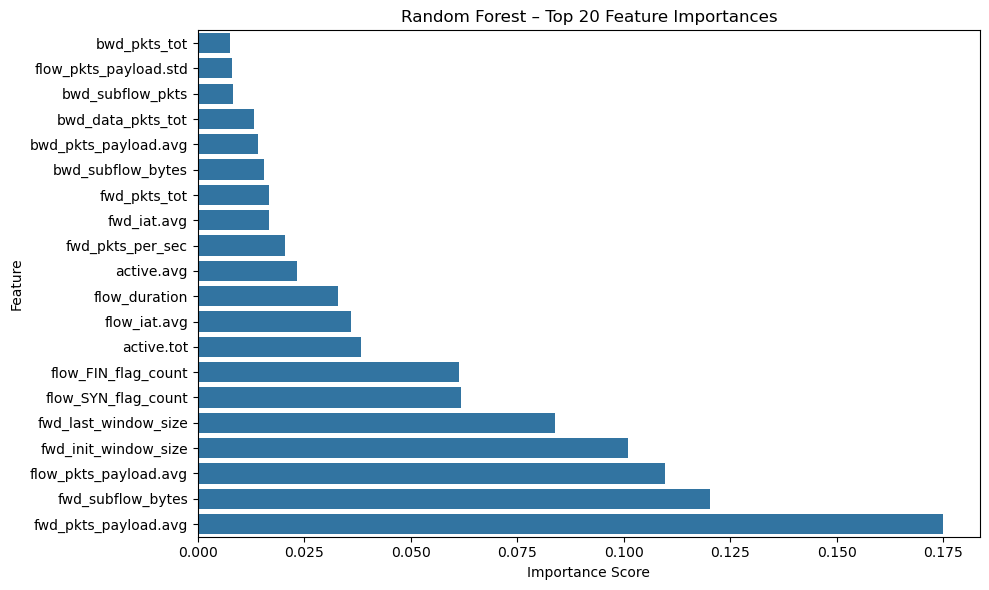

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the best estimator
best_rf = rf_grid.best_estimator_.named_steps['classifier']
rf_importances = best_rf.feature_importances_

# Plot
top_idx = np.argsort(rf_importances)[-20:]  # top 20
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances[top_idx], y=np.array(numeric_features)[top_idx])
plt.title("Random Forest – Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## CatBoost Classifier 

In [96]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 11.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [catboost]1/2 [catboost]
Note: you may need to restart the kernel to use updated packages.


In [98]:
from catboost import CatBoostClassifier

baseline_cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    verbose=100,
    random_state=88,
    early_stopping_rounds=50
)

baseline_cb.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)

0:	learn: 0.9850303	test: 0.9852547	best: 0.9852547 (0)	total: 97.2ms	remaining: 1m 37s
100:	learn: 0.9967299	test: 0.9966688	best: 0.9966688 (99)	total: 2.79s	remaining: 24.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9966688153
bestIteration = 99

Shrink model to first 100 iterations.


### Evaluate Baseline for CatBoost

In [100]:
def evaluate(model, X, y, label='Set'):
    preds = model.predict(X)
    f1 = f1_score(y, preds, average='macro')
    print(f"\n{label} F1 Macro Score: {f1:.4f}")
    print(classification_report(y, preds, target_names=label_encoder.classes_))

evaluate(baseline_cb, X_train, y_train, label='Train')
evaluate(baseline_cb, X_val, y_val, label='Validation')


Train F1 Macro Score: 0.9759
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98      5425
      DOS_SYN_Hping       1.00      1.00      1.00     66261
  NMAP_OS_DETECTION       1.00      1.00      1.00      1400
      NMAP_TCP_scan       1.00      0.99      1.00       702
      NMAP_UDP_SCAN       0.91      0.97      0.94      1813
NMAP_XMAS_TREE_SCAN       1.00      0.99      0.99      1407
      other_attacks       0.94      0.90      0.92       419

           accuracy                           1.00     77427
          macro avg       0.98      0.98      0.98     77427
       weighted avg       1.00      1.00      1.00     77427


Validation F1 Macro Score: 0.9766
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00      1.00       200
      NMAP_TCP_s

### GridSearchCV for Fine-Tuning

In [104]:
params = {
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

cat_model = CatBoostClassifier(
    iterations=500,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    verbose=0,
    random_state=88
)

grid = GridSearchCV(
    estimator=cat_model,
    param_grid=params,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'depth': 8, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


### Evaluate Best Model on Validation and Test

In [106]:
best_model = grid.best_estimator_

# On validation set
evaluate(best_model, X_val, y_val, label='Validation (Tuned)')

# On test set
evaluate(best_model, X_test, y_test, label='Test (Tuned)')


Validation (Tuned) F1 Macro Score: 0.9796
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00      1.00       200
      NMAP_TCP_scan       1.00      1.00      1.00       100
      NMAP_UDP_SCAN       0.91      0.97      0.94       259
NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       201
      other_attacks       0.98      0.90      0.94        60

           accuracy                           1.00     11061
          macro avg       0.98      0.98      0.98     11061
       weighted avg       1.00      1.00      1.00     11061


Test (Tuned) F1 Macro Score: 0.9717
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98      1550
      DOS_SYN_Hping       1.00      1.00      1.00     18932
  NMAP_OS_DETECTION       1.00      1.00      1.00       400
 

## Ensemble model with 3 best performing models 
1. XGB
2. RF 
3. CatBoost 
- implemented with soft voting 

In [109]:
best_xgb_model = xgb_grid.best_estimator_

best_rf_model = rf_grid.best_estimator_

best_catboost_model = grid.best_estimator_

In [111]:
xgb_importances = xgb_model.feature_importances_
rf_importances = rf_model.feature_importances_
catboost_importances = best_catboost_model.get_feature_importance(prettified=False)

In [113]:
# Normalize
xgb_importances /= np.sum(xgb_importances)
rf_importances /= np.sum(rf_importances)
catboost_importances /= np.sum(catboost_importances)

# Average
mean_importance = (xgb_importances + rf_importances + catboost_importances) / 3

# Create DataFrame
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importance
}).sort_values(by='Importance', ascending=False)

top_5 = importance_df.head(5)
print(top_5)

                 Feature  Importance
3      bwd_data_pkts_tot    0.173785
10  fwd_pkts_payload.avg    0.123487
34  fwd_last_window_size    0.102621
6    flow_FIN_flag_count    0.094102
24     fwd_subflow_bytes    0.076664


In [115]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, classification_report

# Create soft voting ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', best_xgb_model),
        ('rf', best_rf_model),
        ('catboost', best_catboost_model)
    ],
    voting='soft'  # soft voting uses predicted probabilities
)

# Fit ensemble on full training data
ensemble_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:14:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..........depth=4, l2_leaf_reg=1, learning_rate=0.1; total time=  43.2s
[CV] END .........depth=4, l2_leaf_reg=5, learning_rate=0.05; total time=  43.0s
[CV] END .........depth=6, l2_leaf_reg=1, learning_rate=0.05; total time= 1.0min
[CV] END ..........depth=6, l2_leaf_reg=3, learning_rate=0.1; total time= 1.0min
[CV] END .........depth=8, l2_leaf_reg=1, learning_rate=0.05; total time= 4.2min
[CV] END .........depth=8, l2_leaf_reg=3, learning_rate=0.05; total time= 4.7min
[CV] END .........depth=4, l2_leaf_reg=3, learning_rate=0.05; total time=  42.5s
[CV] END ..........depth=4, l2_leaf_reg=3, learning_rate=0.1; total time=  43.4s
[CV] END .........depth=6, l2_leaf_reg=1, learning_rate=0.05; total time= 1.0min
[CV] END ..........depth=6, l2_leaf_reg=3, learning_rate=0.1; total time= 1.0min
[CV] END ..........depth=8, l2_leaf_reg=1, learning_rate=0.1; total time= 4.2min
[CV] END ..........depth=8, l2_leaf_reg=3, learning_rate=0.1; total time= 4.7min


VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['flow_duration',
                                                                                 'fwd_pkts_tot',
                                                                                 'bwd_pkts_tot',
                                                                                 'bwd_data_pkts_tot',
                                                                                 'fwd_pkts_per_sec',
                                                                                 'down_up_ratio',
                                                                                 'flow_FIN_flag_count',
                                                                                 'flow_SYN_flag_count',
                                                                                 'flow_RST_flag_count',
                                                                                 '...
                                                                                 'flow_iat.avg',
                                                                                 'fwd_subflow_pkts',
                                                                                 'bwd_subflow_pkts',
                                                                                 'fwd_subflow_bytes',
                                                                                 'bwd_subflow_bytes',
                                                                                 'fwd_bulk_bytes',
                                                                                 'fwd_bulk_packets',
                                                                                 'fwd_bulk_rate',
                                                                                 'bwd_bulk_rate', ...])])),
                                              ('classifier',
                                               RandomForestClassifier(max_depth=10,
                                                                      min_samples_split=5,
                                                                      n_jobs=-1,
                                                                      random_state=88))])),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x16af1fcb0>)],
                 voting='soft')

In [119]:
# Validation performance
train_preds = ensemble_model.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')
print(f"Train F1 Macro Score (Ensemble): {train_f1:.4f}")
print(classification_report(y_train, train_preds, target_names=label_encoder.classes_))

# Validation performance
val_preds = ensemble_model.predict(X_val)
val_f1 = f1_score(y_val, val_preds, average='macro')
print(f"\nValidation F1 Macro Score (Ensemble): {val_f1:.4f}")
print(classification_report(y_val, val_preds, target_names=label_encoder.classes_))

# Test performance
test_preds = ensemble_model.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')
print(f"\nTest F1 Macro Score (Ensemble): {test_f1:.4f}")
print(classification_report(y_test, test_preds, target_names=label_encoder.classes_))


Train F1 Macro Score (Ensemble): 0.9806
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98      5425
      DOS_SYN_Hping       1.00      1.00      1.00     66261
  NMAP_OS_DETECTION       1.00      1.00      1.00      1400
      NMAP_TCP_scan       1.00      1.00      1.00       702
      NMAP_UDP_SCAN       0.92      0.98      0.95      1813
NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00      1407
      other_attacks       0.94      0.94      0.94       419

           accuracy                           1.00     77427
          macro avg       0.98      0.98      0.98     77427
       weighted avg       1.00      1.00      1.00     77427


Validation F1 Macro Score (Ensemble): 0.9794
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTION       1.00      1.00      1.00      

## StackingClassifier with top-3 Tuned models 

In [122]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Define base models (don't re-train)
base_learners = [
    ('xgb', best_xgb_model),
    ('rf', best_rf_model),
    ('catboost', best_catboost_model)
]

# Meta-model (can be anything — often LogisticRegression works well)
meta_learner = LogisticRegression(max_iter=1000, multi_class='multinomial')

# Stacking classifier
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    stack_method='predict_proba',  # uses probabilities (recommended for multiclass)
    n_jobs=-1,
    passthrough=False
)

# Train the stacked model
stacked_model.fit(X_train, y_train_enc)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:16:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[14:17:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[14:17:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[14:17:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



StackingClassifier(cv=3,
                   estimators=[('xgb',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['flow_duration',
                                                                                   'fwd_pkts_tot',
                                                                                   'bwd_pkts_tot',
                                                                                   'bwd_data_pkts_tot',
                                                                                   'fwd_pkts_per_sec',
                                                                                   'down_up_ratio',
                                                                                   'flow_FIN_flag_count',
                                                                                   'flow_SYN_flag_count',
                                                                                   'flow_RST_flag_c...
                                                                                   'fwd_bulk_bytes',
                                                                                   'fwd_bulk_packets',
                                                                                   'fwd_bulk_rate',
                                                                                   'bwd_bulk_rate', ...])])),
                                                ('classifier',
                                                 RandomForestClassifier(max_depth=10,
                                                                        min_samples_split=5,
                                                                        n_jobs=-1,
                                                                        random_state=88))])),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x16af1fcb0>)],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      multi_class='multinomial'),
                   n_jobs=-1, stack_method='predict_proba')

In [123]:
# Train performance
train_preds = stacked_model.predict(X_train)
train_f1 = f1_score(y_train_enc, train_preds, average='macro')
print(f"Train F1 Macro Score (Stacking): {train_f1:.4f}")
print(classification_report(y_train_enc, train_preds, target_names=label_encoder.classes_))

# Validation set
val_preds = stacked_model.predict(X_val)
val_f1 = f1_score(y_val_enc, val_preds, average='macro')
print(f"\nValidation F1 Macro Score (Stacking): {val_f1:.4f}")
print("\nClassification Report (Validation):\n")
print(classification_report(y_val_enc, val_preds, target_names=label_encoder.classes_))

# Test set
test_preds = stacked_model.predict(X_test)
test_f1 = f1_score(y_test_enc, test_preds, average='macro')
print(f"\nTest F1 Macro Score (Stacking): {test_f1:.4f}")
print("\nClassification Report (Test):\n")
print(classification_report(y_test_enc, test_preds, target_names=label_encoder.classes_))

Train F1 Macro Score (Stacking): 0.9809
                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98      5425
      DOS_SYN_Hping       1.00      1.00      1.00     66261
  NMAP_OS_DETECTION       1.00      1.00      1.00      1400
      NMAP_TCP_scan       1.00      1.00      1.00       702
      NMAP_UDP_SCAN       0.92      0.98      0.95      1813
NMAP_XMAS_TREE_SCAN       1.00      0.99      1.00      1407
      other_attacks       0.94      0.94      0.94       419

           accuracy                           1.00     77427
          macro avg       0.98      0.98      0.98     77427
       weighted avg       1.00      1.00      1.00     77427


Validation F1 Macro Score (Stacking): 0.9794

Classification Report (Validation):

                     precision    recall  f1-score   support

     ARP_poisioning       0.99      0.97      0.98       775
      DOS_SYN_Hping       1.00      1.00      1.00      9466
  NMAP_OS_DETECTIO